In [1]:
import toy_data.cov_shift as data_gen
import toy_data as td
import bokeh.io
import numpy as np
import bokeh.plotting as bp
import bokeh.charts as bc
import tensorflow as tf
bokeh.io.output_notebook()

Loading BokehJS ...

In [73]:
# m_ = td.models.LinearBinary(2)
m_ = td.models.rotatedSine2D(phase=np.pi/2, frequency=0.5)
data = data_gen.Gaussian_Shift_2D_BinaryClassification(m_, tst_X_mean_shift=(-1.9, -1.0), noise_sd=0.2)
# data = data_gen.Gaussian_Shift_2D_BinaryClassification(m_,
#                                                        tst_X_mean_shift=(-3, -2.5),
#                                                        noise_sd=0.4,
#                                                        n_samples=400)
data_gen.visualize_2D_classification(data, classifyF=m_, fig_width=800)

### RBA

#### Density estimation using logistic regression
\begin{align}
    \frac{P(X_{\text{tr}})}{P(X_{\text{tst}})} = \frac{P(X\mid s=\text{tr})}{P(X\mid s=\text{tst})}
    &= \frac{\frac{P(s=\text{tr}\mid X)P(X)}{P(s=\text{tr})}}{\frac{P(s=\text{tst}\mid X)P(X)}{P(s=\text{tst})}} \\
    &= \frac{P(s=\text{tr}\mid X)P(s=\text{tst})}{P(s=\text{tst}\mid X)P(s=\text{tr})} \\
    &= \frac{P(s=\text{tst})}{P(s=\text{tr})}\frac{1-P(s=\text{tst}\mid X)}{P(s=\text{tst}\mid X)} \\
    &= \frac{P(s=\text{tst})}{P(s=\text{tr})}(\frac{1}{P(s=\text{tst}\mid X)} - 1)
\end{align}

Hence we can find $P(s=\text{tst}\mid X)$ first and then calculate the ratio from it
\begin{align}
\text{minimize}_{w} -\log p(s=\text{tst}\mid x; w),
\end{align}
which is logistic regression on $x, s$

We just reuse the previous LR model here:

In [74]:
tr = data.tr
tst = data.tst

In [75]:
n_tr = tr.y.shape[0]
n_tst = tst.y.shape[0]

x = tf.placeholder(tf.float32, [None, 2])
W = tf.Variable(tf.random_uniform(shape=[2, 1]), dtype=tf.float32)
b = tf.Variable(tf.random_uniform(shape=[1]), dtype=tf.float32)
logits = tf.matmul(x, W) + b
y = tf.nn.sigmoid(logits)
y_ = tf.placeholder(tf.float32, [None, 1])

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y_)
# loss = tf.reduce_mean(cross_entropy + tf.nn.l2_loss(W))
loss = tf.reduce_mean(cross_entropy)
# train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step = tf.train.RMSPropOptimizer(0.01).minimize(cross_entropy)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

s = np.concatenate((np.zeros(n_tr), np.ones(n_tst))).reshape(-1, 1)

for i in range(1000):
    sess.run(train_step, feed_dict={x: np.vstack((tr.X, tst.X)), y_: s})
    
correct_prediction = tf.equal(y > 0.5, y_>0.5)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(loss, feed_dict={x: np.vstack((tr.X, tst.X)), y_: s}))
print(sess.run(accuracy, feed_dict={x: np.vstack((tr.X, tst.X)), y_: s}))

def logi_classify_F(X):
    return sess.run(y, feed_dict={x: X})

data_gen.visualize_2D_classification(data, classifyF=logi_classify_F, fig_width=400)

0.340512
0.815


* The the ratio is: 
\begin{align}
    &\frac{P(s=\text{tst})}{P(s=\text{tr})}(\frac{1}{P(s=\text{tst}\mid X)} - 1) \\
    &=\frac{P(s=\text{tst})}{P(s=\text{tr})}(\frac{1}{\text{sigmoid}(-wX)} - 1) \\
    &=\frac{P(s=\text{tst})}{P(s=\text{tr})}e^{-wX}
\end{align}

In [76]:
def logi_reweight_F(X):
    _R = sess.run(n_tst/n_tr*(tf.exp(logits)), feed_dict={x: X})
    # _R = sess.run(n_tst/n_tr*(tf.exp(-logits)), feed_dict={x: X})
    return _R
z = np.array([[-2,2]]).T.T
logi_reweight_F(z)

array([[ 0.04471942]], dtype=float32)

In [77]:
def mixed_moments(_l, order):
    if order == 1:
        return _l
    elif order == 0:
        raise Exception('Order must be larger than 0')
    r = (_l[:,[i]] * mixed_moments(_l[:,i:], order - 1) for i in range(_l.shape[1]))
    return np.hstack(r)

def get_moments(_x, order):
    # The hack by https://github.com/tensorflow/tensorflow/issues/956
    _t = np.pad(_x - 1, [[0,0],[1,0]], 'constant') + 1
    return mixed_moments(_t, order)

In [78]:
n_classes = 2
dim_x = data.X.shape[1]
ys = np.eye(n_classes)
order_moments = 3
n_dim_m = mixed_moments(np.array([[0]*(dim_x + 1)]), order_moments).shape[1]

In [79]:
tr_y_1hot = np.hstack((tr.y, 1 - tr.y))
m_tr = get_moments(tr.X, order_moments)
m_tr = m_tr[:, :, np.newaxis, np.newaxis]
# tr_y_1hot.shape
tr_y_1hot_4D = tr_y_1hot[:, np.newaxis, :, np.newaxis]

m_all = get_moments(data.X, order_moments)
m_d_all = m_all[:,:, np.newaxis, np.newaxis]*ys[np.newaxis, np.newaxis, :, :]
reweight_all = logi_reweight_F(data.X)

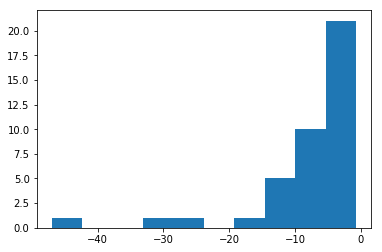

In [80]:
import matplotlib.pyplot as plt
plt.hist(-1/logi_reweight_F(data.tst.X))
plt.show()

In [81]:
min_eps = 0.00001
max_iter = 100000
lr = 0.00001
l_theta = 0.01
theta = np.zeros((n_dim_m, n_classes))

In [82]:
E_m_tr

array([[ 0.4       ,  0.6       ],
       [-0.271747  ,  0.73711733],
       [ 0.57794   , -0.45818249],
       [ 1.29455575,  1.86670795],
       [-0.04839595, -0.5820781 ],
       [ 1.81561714,  1.12509832],
       [-1.85241531,  4.78331694],
       [ 1.83717765, -1.38288405],
       [-0.73421009,  1.6089592 ],
       [ 5.56013163, -2.82147011]])

In [83]:
def softmax(x, max_dim):
    e_x = np.exp(x - np.max(x, axis=max_dim, keepdims=True))
    return e_x / e_x.sum(axis=max_dim, keepdims=True)

def RBA_predict_all(theta):
    pm_c = -1/reweight_all[:, :, np.newaxis, np.newaxis]*m_d_all*theta[np.newaxis, :, :, np.newaxis]
    p_c = np.sum(pm_c, axis=1, keepdims=True)
    return softmax(p_c, 3)
    
def E(_m, _p):
    _Em = np.mean(_m*_p, axis=0)
    return np.sum(_Em, axis=2)

E_m_tr = E(m_tr, tr_y_1hot_4D)
    
_iter = 0
while True:
    _iter += 1
    pred = RBA_predict_all(theta) 
    dL = E_m_tr - E(m_d_all, pred)
    regular_grad = 2*theta/(np.linalg.norm(theta.ravel()) + 1e-9)
    theta_inc = dL + l_theta*regular_grad
    theta -= lr * theta_inc
    eps = np.linalg.norm(theta_inc)
    if not (_iter % 1000): # and _iter % 1001 and _iter % 1002):
        print(eps, np.linalg.norm(theta.ravel()))
        # print(theta.T)
        # print(l_theta*regular_grad.T)
    if eps < min_eps or _iter >= max_iter: 
        break

2.38533989075 0.0303036508631
2.03406457132 0.0519995909213
1.87573342927 0.0713026996284
1.7857597496 0.0893952427494
1.72803491548 0.10676352546
1.68795175818 0.123653387007
1.65851122077 0.140204859694
1.63596840622 0.156504716345
1.61815005009 0.172610297116
1.60371240459 0.188561467668
1.59178125694 0.204387101072
1.58176367471 0.220108816775
1.57324321323 0.23574325237
1.56591847268 0.251303506225
1.55956550179 0.266800088837
1.55401397569 0.282241570839
1.54913165716 0.297635036872
1.54481400297 0.312986411359
1.5409770488 0.328300697483
1.53755242919 0.34358215603
1.53448381661 0.35883444169
1.53172432357 0.374060708691
1.52923457199 0.389263693928
1.52698123395 0.404445783283
1.52493591127 0.419609065211
1.52307426104 0.434755374509
1.52137529801 0.449886328434
1.51982080835 0.465003356799
1.51839476651 0.480107727318
1.51708243851 0.495200567347
1.515868069 0.510282883262
1.51472812128 0.525355579063
1.51362227585 0.540419473523
1.51253275796 0.555475302626
1.51152068768 0.57

In [86]:
def RBA_predict(x, theta):
    m = get_moments(x, order_moments)
    m_d = m[:,:, np.newaxis, np.newaxis]*ys[np.newaxis, np.newaxis, :, :]
    # m_d.shape = (n_data, n_moments, n_classes, n_classes)
    pm_c = -1/logi_reweight_F(x)[:, :, np.newaxis, np.newaxis]*m_d*theta[np.newaxis, :, :, np.newaxis]
    p_c = np.sum(pm_c, axis=1, keepdims=True)
    return softmax(p_c, 3)

def RBA_F(x):
    pred = RBA_predict(x, theta)
    np.set_printoptions(precision=2, suppress=True)
    print(pred[0:5,0,:,:])
    np.set_printoptions(precision=8, suppress=False)
    print(pred.shape)
    return pred[:, 0, 0, 0]
data_gen.visualize_2D_classification(data, classifyF=RBA_F, fig_width=600)

[[[ 0.37  0.63]
  [ 0.91  0.09]]

 [[ 0.36  0.64]
  [ 0.91  0.09]]

 [[ 0.35  0.65]
  [ 0.91  0.09]]

 [[ 0.34  0.66]
  [ 0.91  0.09]]

 [[ 0.33  0.67]
  [ 0.91  0.09]]]
(22500, 1, 2, 2)
